In [3]:
DATA_DIR = "/home/anton/CodeSearchNet/dataset/CodeXGLUE-source-code-asts"

# EDA

In [4]:
import pickle
from utils.vocabulary import Vocabulary

100%|██████████| 164923/164923 [00:43<00:00, 3786.62it/s]


Count 40809 label, top-5: [('the', 152443), ('a', 68773), ('to', 43936), ('of', 39969), ('for', 26049)]
Count 67359 token, top-5: [('get', 362013), ('if', 249391), ('string', 226771), ('return', 189018), ('new', 183344)]
Count 388 node, top-5: [('expression|primary|IDENTIFIER', 1884481), ('IDENTIFIER', 1845599), ('LPAREN', 1799808), ('RPAREN', 1796565), ('expression', 1649746)]


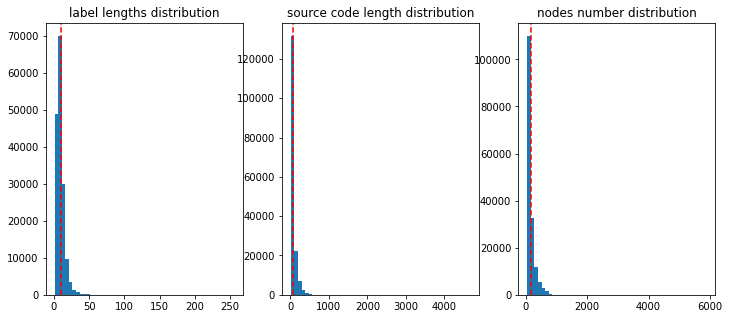

min label length: 1, max label length: 255, average: 9.686192950649698
min source code length: 11, max source code length: 4666, average: 9.686192950649698
min nodes number: 39, max nodes number: 5882, average: 156.19118618991894


In [5]:
label_lens, source_lens, n_nodes = Vocabulary.build_from_scratch(
    f"{DATA_DIR}/codexglue-docstrings-java/codexglue-docstrings-java.train.jsonl"
)

In [6]:
with open(f"{DATA_DIR}/codexglue-docstrings-java/vocabulary.pkl", 'rb') as f:
    feat_cnts = pickle.load(f)

feat_cnts['token'].keys()

dict_keys(['public', 'static', 'string', 'minimal', 'to', 'object', 'return', 'get', 'class', 'name', 'integer', 'hex', 'system', 'identity', 'hash', 'code', 'map', 'jsp', 'attributes', 'if', 'null', 'this', 'new', 'reply', 'as', 'byte', 'switch', 'v4', 'v4a', 'codes', 'case', 'request', 'granted', 'rejected', 'or', 'failed', 'no', 'identd', 'because', 'client', 'is', 'not', 'running', 'reachable', 'from', 'the', 'server', 'id', 'confirmed', 's', 'could', 'confirm', 'user', 'in', 'v5', 'succeeded', 'general', 'failure', 'socks', 'allowed', 'connection', 'by', 'ruleset', 'network', 'unreachable', 'host', 'refused', 'ttl', 'expired', 'command', 'supported', 'address', 'type', 'default', 'unknown', 'uri', 'create', 'entry', 'r', 'path', 'file', 'use', 'archive', 'empty', 'urls', 'for', 'jar', 'zip', 'data', 'now', 'wsjar', 'avoid', 'locking', 'issues', 'via', 'protocol', 'single', 'constructor', 'used', 'control', 'encoding', 'an', 'ddecoding', 'value', 'of', 'parent', 'encoded', 'handler

In [7]:
import matplotlib.pyplot as plt
import numpy as np

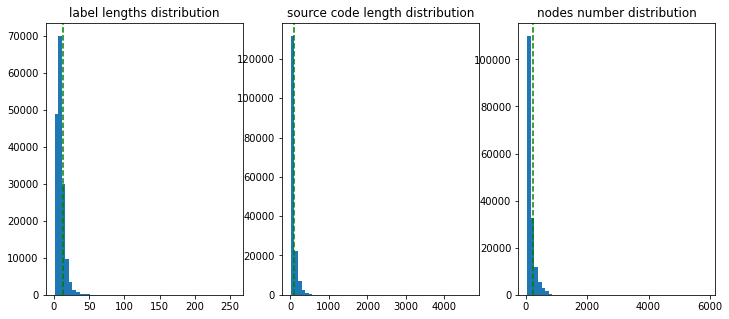

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.set_title('label lengths distribution')
ax1.hist(label_lens, bins=50)
ax1.axvline(x=np.percentile(label_lens, 80), ls='--', color='green')
ax2.set_title('source code length distribution')
ax2.hist(source_lens, bins=50)
ax2.axvline(x=np.percentile(source_lens, 80), ls='--', color='green')
ax3.set_title('nodes number distribution')
ax3.hist(n_nodes, bins=50)
ax3.axvline(x=np.percentile(n_nodes, 80), ls='--', color='green')

plt.show()

In [9]:
print(f"label threshold: {np.percentile(label_lens, 80)}, source code threshold {np.percentile(source_lens, 80)}, nodes threshold: {np.percentile(n_nodes, 80)}")

label threshold: 13.0, source code threshold 105.0, nodes threshold: 218.0


# Trt running

In [1]:
import hydra
import torch
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning import seed_everything, Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

from data_module.jsonl_data_module import JsonlDataModule
from models import CodeGNNGRU

In [2]:
config = OmegaConf.load("configs/codegnn_codexglue_java.yaml")

In [3]:
data_module = JsonlDataModule(config)
data_module.prepare_data()
data_module.setup()


Dataset is already downloaded


In [4]:
model = CodeGNNGRU(config, data_module.vocabulary)

In [5]:
gpu = 1 if torch.cuda.is_available() else None
wandb_logger = WandbLogger(project=f"codegnn-{config.dataset}", log_model=False, offline=config.log_offline)
wandb_logger.watch(model)

wandb: Currently logged in as: strange_attractor (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
trainer = Trainer(
    max_epochs=config.hyper_parameters.n_epochs,
    gradient_clip_val=config.hyper_parameters.clip_norm,
    deterministic=True,
    check_val_every_n_epoch=config.val_every_epoch,
    logger=wandb_logger,
    gpus=gpu,
    progress_bar_refresh_rate=config.progress_bar_refresh_rate,
    resume_from_checkpoint=config.resume_checkpoint,
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [7]:
trainer.fit(model=model, datamodule=data_module)


  | Name            | Type       | Params
-----------------------------------------------
0 | token_embedding | Embedding  | 5.8 M 
1 | node_embedding  | Embedding  | 49.9 K
2 | source_code_enc | GRU        | 296 K 
3 | gcn_layers      | ModuleList | 33.0 K
4 | ast_rnn_enc     | GRU        | 296 K 
5 | decoder         | GRUDecoder | 4.0 M 
-----------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/anton/opt-met-exps/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/anton/opt-met-exps/lib/python3.8/site-packages/torch/nn/modules/module.py:785: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "
/home/anton/opt-met-exps/lib/python3.8/site-packages/torch/nn/modules/module.py:770: UserWarnin

1